In [ ]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
import csv
import pickle
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns


# Extracing a csv file with labels and times to event 
# survival and recurrence task

In [ ]:

csv_file_path = '/data_slow2/ve59kedo/patched_256/process_list_autogen.csv'
json_file_path = '/data_slow2/ve59kedo/seg/json/clinical_data.json'
output_csv_path = '/data/ve59kedo/thesis/test.csv'

df_csv = pd.read_csv(csv_file_path)

df_csv['patient_id'] = df_csv['slide_id'].str.extract('PrimaryTumor_HE_(\d+)')
df_csv['patient_id'] = 'PrimaryTumor_HE_' + df_csv['patient_id'].str.zfill(3)

with open(json_file_path, 'r') as file:
    clinical_data = json.load(file)

df_json = pd.DataFrame(clinical_data)
df_json['patient_id'] = df_json['patient_id'].astype(str)
df_json['patient_id'] = 'PrimaryTumor_HE_' + df_json['patient_id'].str.zfill(3)

columns_to_merge = ['patient_id', 'days_to_last_information', 'survival_status_with_cause', 'recurrence', 'days_to_recurrence']

result_df = pd.merge(df_csv[['patient_id']], df_json[columns_to_merge], on='patient_id', how='left')

result_df.to_csv(output_csv_path, index=False)

df = pd.read_csv(output_csv_path)

df.insert(0, 'case_id', df['patient_id'])

df.loc[df.duplicated('patient_id'), 'patient_id'] = df['patient_id'] + '_a'
df.to_csv(output_csv_path, index=False)

print("The data has been processed and saved to", output_csv_path)


# filtering the csv files 

In [12]:
# survival task
csv_file = '/data/ve59kedo/thesis/clam/CLAM/dataset_csv/surv.csv'
output_csv_file = '/data/ve59kedo/thesis/clam/CLAM/dataset_csv/risk_surv_test.csv'

df = pd.read_csv(csv_file)

filtered_df = df[~((df['label'] == 'tod') & (df['time'] > 800))]
filtered_df = df[~((df['label'] == 'lebt') & (df['time'] < 800))]

filtered_df.to_csv(output_csv_file, index=False)

KeyError: 'time'

In [ ]:
Threshold_1 = 365 * 1 # change according to the 2, 3, 4 or 5

df = pd.read_csv('/data_slow2/ve59kedo/filtered_tasks/DSTMA_full.csv')
df = df[df['survival_status_with_cause'].isin(['living', 'deceased tumor specific', 'deceased'])]

df = df[~((df['days_to_last_information'] < Threshold_1) & (~df['survival_status_with_cause'].isin(['deceased tumor specific', 'deceased'])))]

df.loc[df['days_to_last_information'] > Threshold_1, 'survival_status_with_cause'] = 'living'

df = df.drop(columns=['recurrence', 'days_to_recurrence'])

df.to_csv('/data_slow2/ve59kedo/filtered_tasks/Th_1_TMA_surv.csv', index=False)

No categories found for legend.


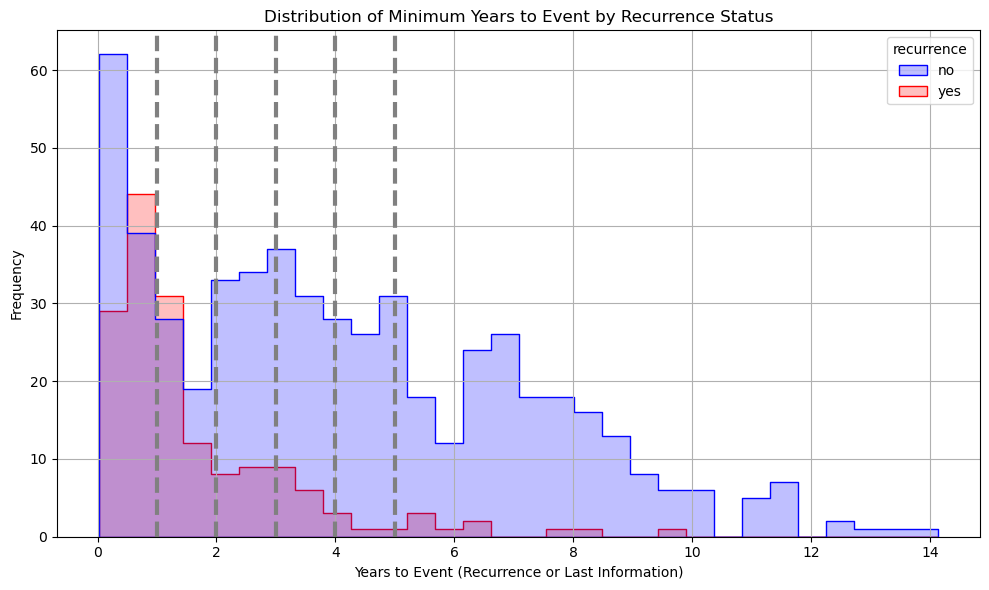

In [10]:


csv_file_path = '/data_slow2/ve59kedo/filtered_tasks/WSI_full.csv'
df = pd.read_csv(csv_file_path)

df = df.dropna(subset=['days_to_recurrence', 'days_to_last_information'], how='all')

df['min_days'] = df[['days_to_recurrence', 'days_to_last_information']].min(axis=1, skipna=True)

df['years_min_days'] = df['min_days'] / 365.25

df['recurrence'] = df['recurrence'].astype('category')

palette = {"yes": "red", "no": "blue"}

plt.figure(figsize=(10, 6))
plot = sns.histplot(
    data=df, 
    x='years_min_days', 
    hue='recurrence', 
    element='step', 
    palette=palette, 
    bins=30
)

plt.title('Distribution of Minimum Years to Event by Recurrence Status')
plt.xlabel('Years to Event (Recurrence or Last Information)')
plt.ylabel('Frequency')

# Adding threshold lines if needed (can adjust or remove)
plt.axvline(1, color='gray', linestyle='--', lw=3)
plt.axvline(2, color='gray', linestyle='--', lw=3)
plt.axvline(3, color='gray', linestyle='--', lw=3)
plt.axvline(4, color='gray', linestyle='--', lw=3)
plt.axvline(5, color='gray', linestyle='--', lw=3)

handles, labels = plot.get_legend_handles_labels()
if labels:
    plt.legend(handles=handles, title='Recurrence Status')
else:
    print("No categories found for legend.")

plt.grid(True)
plt.tight_layout()
plt.show()


# Aggregation of TMAs and WSI

In [1]:
import os
import torch
import h5py
import numpy as np

dstma_folder = '/data_slow2/ve59kedo/UNI_DSTMA_feat2_256'
primary_folder = '/data_slow2/ve59kedo/UNI_WSI_feat_256_full'
output_folder = '/data_slow2/ve59kedo/UNI_AG2_infer'

h5_output_folder = os.path.join(output_folder, 'h5_files')
pt_output_folder = os.path.join(output_folder, 'pt_files')

os.makedirs(h5_output_folder, exist_ok=True)
os.makedirs(pt_output_folder, exist_ok=True)

def get_ids_and_paths(folder, pattern):
    files = os.listdir(folder)
    id_to_file = {}
    for f in files:
        if f.startswith(pattern):
            id_part = f.split('_')[-1].split('.')[0]
            id_to_file[id_part] = os.path.join(folder, f)
    return id_to_file

dstma_ids = get_ids_and_paths(os.path.join(dstma_folder, 'pt_files'), 'DSTMA')
primary_ids = get_ids_and_paths(os.path.join(primary_folder, 'pt_files'), 'PrimaryTumor_HE')

common_ids = set(dstma_ids.keys()).intersection(set(primary_ids.keys()))

def concatenate_and_save_pt(id_, output_folder):
    dstma_tensor = torch.load(dstma_ids[id_])
    primary_tensor = torch.load(primary_ids[id_])
    concatenated_tensor = torch.cat((dstma_tensor, primary_tensor), dim=0)
    torch.save(concatenated_tensor, os.path.join(output_folder, f'AG2_{id_}.pt'))

def concatenate_and_save_h5(id_, output_folder):
    with h5py.File(os.path.join(dstma_folder, 'h5_files', f'DSTMA_{id_}.h5'), 'r') as dstma_h5, \
         h5py.File(os.path.join(primary_folder, 'h5_files', f'PrimaryTumor_HE_{id_}.h5'), 'r') as primary_h5:
        dstma_coords = np.array(dstma_h5['coords'])
        primary_coords = np.array(primary_h5['coords'])
        dstma_feat = np.array(dstma_h5['features'])
 


# Aggregation the csv files

In [1]:
# change the th_X as needed

input_csv_path = '/data_slow2/ve59kedo/filtered_tasks/Th_4_WSI_surv.csv'
pt_files_folder = '/data_slow2/ve59kedo/UNI_AG2/pt_files'
output_csv_path = '/data_slow2/ve59kedo/filtered_tasks/th_4_AG2_surv.csv'

pt_file_ids = {os.path.splitext(f)[0].split('_')[1] for f in os.listdir(pt_files_folder) if f.startswith('AG2_') and f.endswith('.pt')}

non_matching_rows = []

with open(input_csv_path, mode='r', newline='', encoding='utf-8') as input_csv_file:
    reader = csv.DictReader(input_csv_file)
    fieldnames = reader.fieldnames

    with open(output_csv_path, mode='w', newline='', encoding='utf-8') as output_csv_file:
        writer = csv.DictWriter(output_csv_file, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            case_id = row['case_id']
            patient_id = case_id.split('_')[-1]

            if patient_id in pt_file_ids:
                writer.writerow(row)
            else:
                non_matching_rows.append(row)

print("Rows that didn't match any AG2_XXX ID:")
for row in non_matching_rows:
    print(row)

print(f"Filtered CSV written to: {output_csv_path}")


Rows that didn't match any AG2_XXX ID:
{'case_id': 'PrimaryTumor_HE_437', 'patient_id': 'PrimaryTumor_HE_437', 'days_to_last_information': '1684', 'survival_status_with_cause': 'living'}
Filtered CSV written to: /data_slow2/ve59kedo/filtered_tasks/th_4_AG2_surv.csv
